# Tutorial for BayBooNE: Baysian Booster Neutrino Experiment python package


This package is designed to use Bayesian parameter estimation to find sterile neutrino oscillation parameters ($\Delta m_{14}^2, sin^2 2\theta_{14}$) from a data sample containing initial muon neutrino flux and number of electron neutrinos detected at a particular neutrino energy.

To do so, we first simulate a short-baseline neutrino oscillation dataset for a particular ($\Delta m^2, sin^2 2\theta$) pair, and then use a pymc3-based algorithm to infer the parameters from our simulated data.

In [1]:
# Pacakge dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns

# Inference package componenets
import bayboone.data_io as makeData
from bayboone.inference import module as ifunc

#Allows reimporting the package without restarting the kernel
import importlib

## Create a sample dataset by simulating data based on short baseline experiments.

Our simulation draws from known values of neutrino energy E, distance from detector L, to calculate $\nu_\mu$ to $\nu_e$ oscillation probability, and then adjusts for overall flux (in progress). 

Importantly, we use $$ P_{\nu_{\mu} -> \nu_{e-}} = sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E})$$ to get the oscillation probability, and then simulate a certain number of muon neutrinos which randomly oscillate to electron neutrinos based on the $P_{\nu_{\mu} -> \nu_{e-}}$ for the neutrino.


In [ ]:
# To simulate a sample number of nues detected in a microboone-like experiment
# Arguments are number of muon nuetrinos sent by the beam, sin^2_2theta, delta_m^2
uboone_data = makeData.Data.simulate_microboone(600000, 0.5, 0.8)
uboone_numu, uboone_nue = uboone_data.N_numu, uboone_data.N_nue

# To simulate a sample from a generic detector
# Arguments are number of numus, sin^2_2theta, delta_m^2, detector baseline L, neutrino energy E, uncertainty in L, uncertainty in E
generic_data = makeData.Data.simulate_detector(100000, 0.7, 4, 0.5, 1, 0.1, 10e-3)
generic_numu, generic_nue = generic_data.N_numu, generic_data.N_nue
# These values were chosen to illustrate the shape of the model, rather than to be realistic

In [ ]:
# Maybe add something that plots oscillation probability as a function of mixing parameters so we can see how they're correlated?
# could probably use one of the functions from data_io for this.


## Infer $\Delta m^2$ and $sin^2 2\theta$ from our simulated data.

We make use of three functions from our inference_functions pacakge (imported here as ifunc):

-  oscillation_model: sets up our model in pymc3
-  fit_model: fits data to the statistical model
-  print_fit_vals: prints the quartile intervals for the fits on our mixing parameters

Our statistical model for predicting how many electron neutrinos appear is given by:

\begin{align}
    sin^2(2\theta) &\sim \text{Uniform(0.0001, 1)} \\
    \Delta m^2 &\sim \text{Jeffreys(0.01, 10)} \\
    L &\sim \text{Truncated Normal}(\mu = 0.5, \sigma = 0.05) \\
    E &\sim \text{Truncated Normal}(\mu = 1.0, \sigma = 0.05) \\
    \text{rate} &= \#\nu_{mu}sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E}) \\
    \#\nu_{e-} &\sim \text{Poisson}(\mu = \text{rate})
\end{align}
We're treating the distributions of L and E as priors rather than known parameters due to their associated uncertainties - based on the way neutrinos beams produce neutrinos, both distance travelled and energy is variable.


Pymc3 transforms some of these distributions for ease of computation, so the pymc3 model used is printed by the next cell.

In [ ]:
importlib.reload(ifunc)
ifunc.oscillation_model(600000, 10)

Now we're going to use our package to do basic MCMC inference on the neutrino mixing parameters. We'll treat L and E as nuisance parameters for this project.

/home/jybook/anaconda3/envs/phys201b/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E, L, log_delta_m^2, sin^2_2theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7182313890262789, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


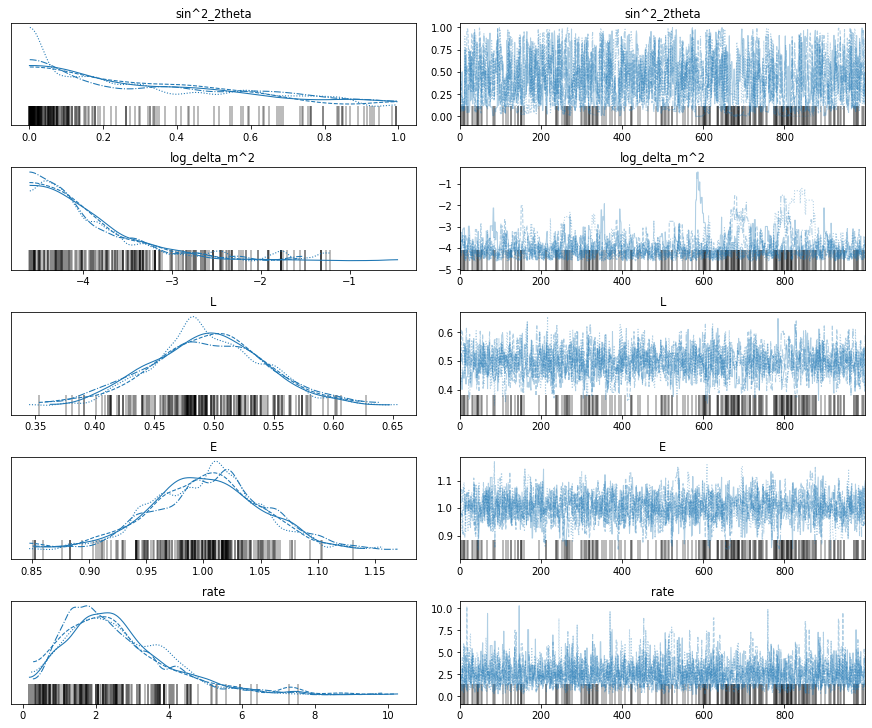

In [2]:
importlib.reload(ifunc) # Make sure you're using the most up-do-date version of the module. Will be removed once package is stable
data = [60000, 2]
#After merge, should be able to use data as defined above instead of the points
#The points here should correspond to dms = 0.8 eV^2, ss2t = 0.5
trace = ifunc.fit_model(data[0], data[1])

Now, let's take our output and look at the marginalized distributions of $sin^2(2\theta)$ and $\Delta m^2$

In [3]:
df_trace = pm.trace_to_dataframe(trace)
df_trace['delta_m^2'] = np.exp(df_trace['log_delta_m^2'])

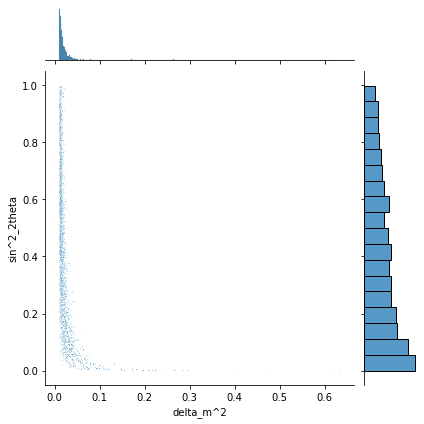

In [4]:
joint_kde = sns.jointplot(x='delta_m^2', y='sin^2_2theta', data=df_trace, kind='scatter', s=0.2)

As a final step, we'll take a look at the quartile intervals of the posterior distributions for our mixing parameters.

In [5]:
ifunc.print_fit_vals(trace)

delta_m^2 = 0.02 + 0.02 - 0.00
sin^2_2theta = 0.3 + 0.4 - 0.3


True

While the quartile ranges for the estimates on $\Delta m^2$ and $sin^2(2\theta)$ include the values we used to generate data, they're so large as to not be too useful yet. This is to a large extent an effect of the high correlation between the two mixing parameters. We're working on finding an appropriate reparameterization of the model that avoids these pitfalls.